# Bootstrap analysis of all task's subtypes

In [16]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting

In [17]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [20]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno'
mask_path = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'

In [21]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))

In [22]:
df_stack.head()

,sub1_fear,sub2_fear,sub3_fear,sub4_fear,sub5_fear,sub1_win,sub2_win,sub3_win,sub4_win,sub5_win,...,sub1_tools,sub2_tools,sub3_tools,sub4_tools,sub5_tools,sub1_0bk,sub2_0bk,sub3_0bk,sub4_0bk,sub5_0bk
0,0.445295,-0.164905,-0.322196,0.723914,-0.480451,-0.848522,0.885702,-0.144686,1.670798,-1.080155,...,-0.252861,0.019524,0.500804,-0.066092,-0.087294,-0.453810,0.212479,0.052814,0.740018,-0.271175
1,0.434186,-0.314472,-0.155334,0.722393,-0.573545,-0.906281,1.147090,-0.237425,1.706425,-1.175707,...,-0.178494,0.121129,0.473746,-0.377560,-0.129918,-0.570569,0.253645,0.404401,0.958110,-0.402284
2,0.416064,-0.359790,0.154968,0.390277,-0.634017,-1.008891,0.991756,-0.451814,1.673089,-0.689594,...,-0.186201,0.032371,0.494219,-0.254295,-0.074770,-0.290059,0.236070,-0.231466,0.635724,-0.248564
3,0.513731,-0.058470,-0.354486,0.646190,-0.506626,-0.722472,0.688799,0.282264,1.051600,-1.127927,...,-0.206851,0.194891,0.389976,-0.407788,-0.119408,-0.354973,0.318086,0.383656,0.311867,-0.313932
4,0.493780,-0.092133,-0.328708,0.639193,-0.493909,-0.747647,0.701606,0.215737,1.133683,-1.092352,...,-0.216314,0.197104,0.445557,-0.410383,-0.155218,-0.339594,0.331793,0.346455,0.326022,-0.325737


In [23]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [24]:
# push it to octave
%octave_push y
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

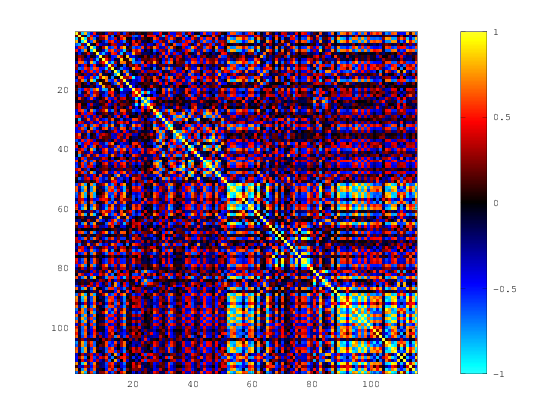

In [25]:
%%octave
nb_cluster =7;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

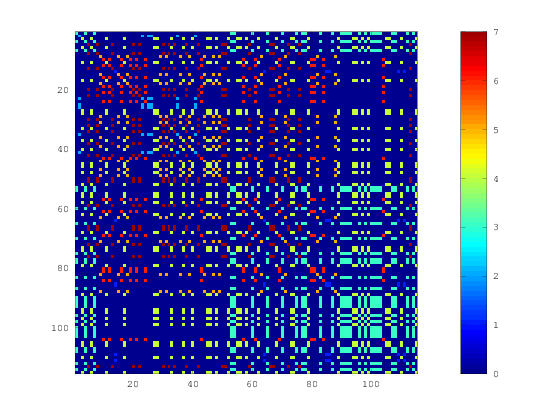

In [26]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

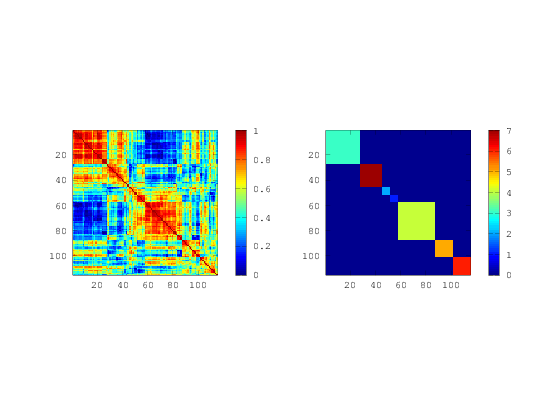

In [27]:
%%octave
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

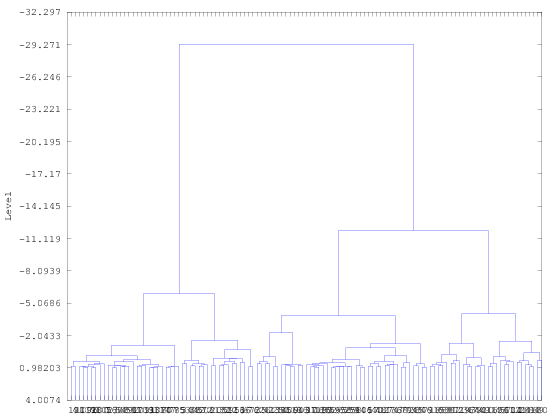

In [28]:
%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [29]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

In [60]:
%%octave -i path_root -o stab_tmp
save( [path_root filesep 'stability_maps_' date '.mat'],'stab')
stab_tmp = load([path_root filesep 'stability_maps_weights_' date '.mat']);

In [61]:
%%octave
stab_m= (stab+stab_tmp.stab)/2;
size(stab_m)

ans =

   115   115

Let's have a look at the stability matrix:

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

ans =  3

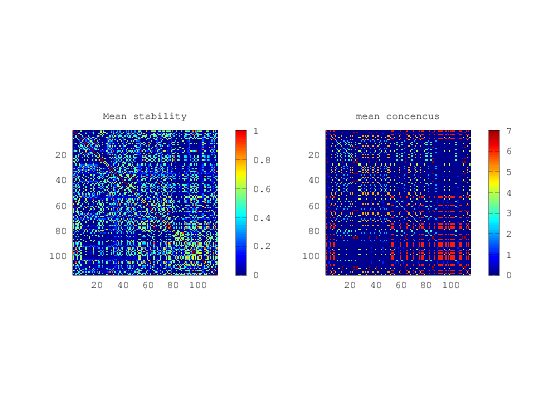

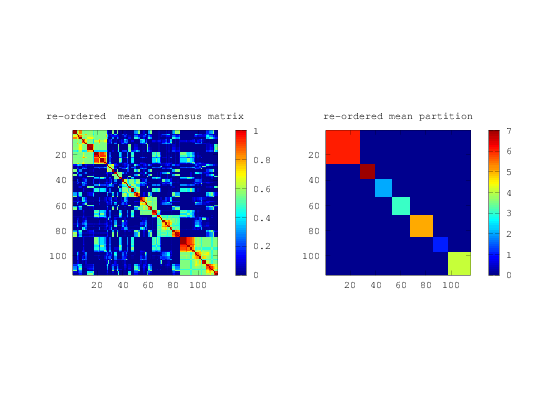

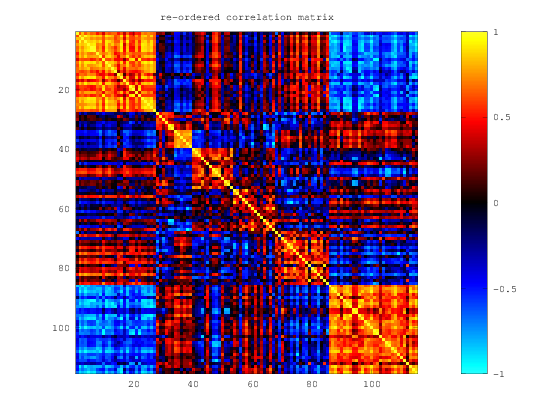

In [88]:
%%octave
subplot(1,2,1)
imagesc(stab_m), axis square, colormap(jet), colorbar, title('Mean stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab_m); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('mean concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab_m(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  mean consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered mean partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

ans =  3

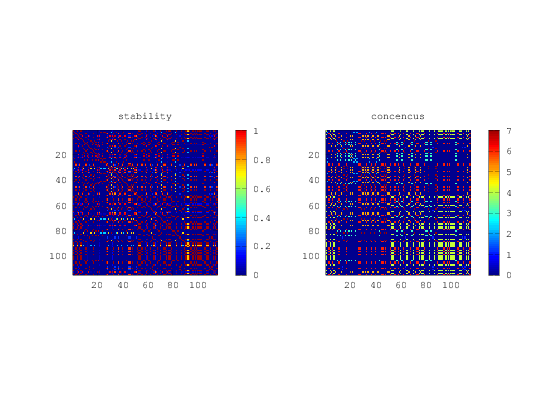

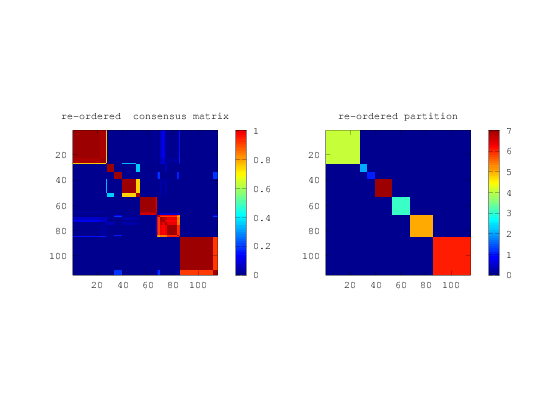

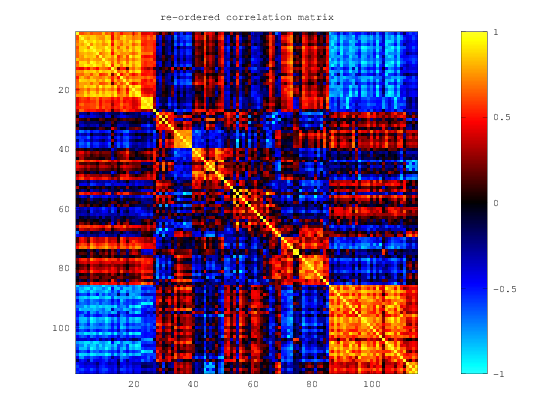

In [90]:
%%octave
subplot(1,2,1)
imagesc(stab), axis square, colormap(jet), colorbar, title('stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

In [ ]:
%octave imagesc(stab_m), axis square, colormap(jet), colorbar, title('Mean stability')

In [63]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab_m); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy

     Percentage done : 0 5 11 16 20 25 31 35 40 46 50 55 61 66 70 75 81 85 90 96 100 Done ! 

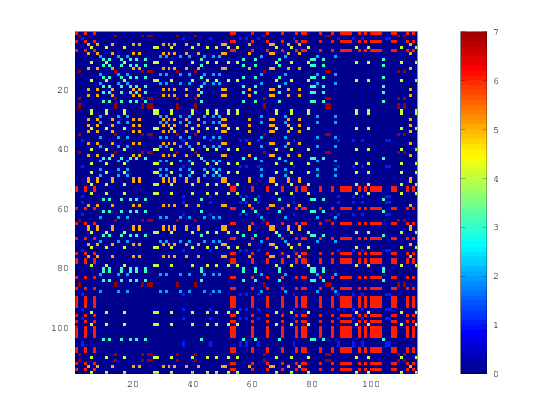

In [64]:
%octave niak_visu_part(part_consensus), axis square, colormap(jet) # visualize the consensus partition

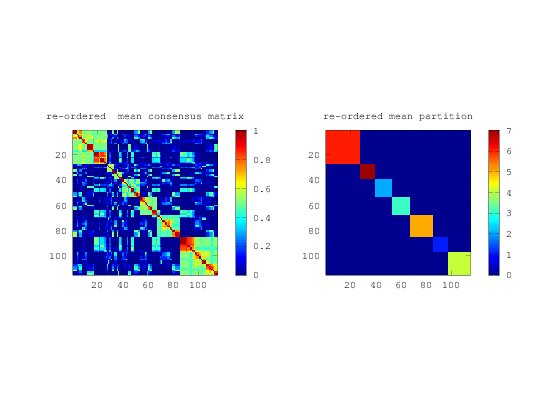

In [83]:
%%octave
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab_m(order_consensus,order_consensus)), axis square, colorbar, title('re-ordered  mean consensus matrix')
subplot(1,2,2)
# Show the re-ordered partition
niak_visu_part(part_consensus(order_consensus)), axis square,title('re-ordered mean partition')

In [34]:
#%octave niak_visu_dendrogram(hier_consensus)

ans =  1

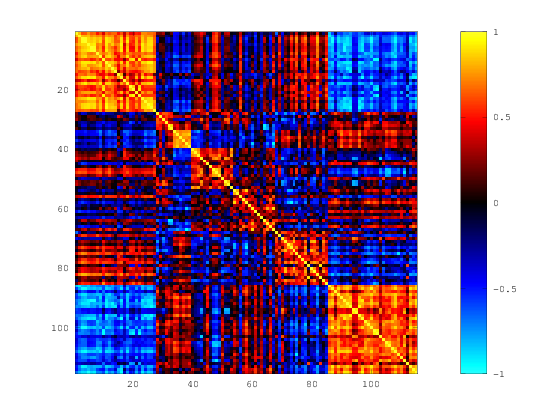

In [66]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [91]:
%%octave -o stack
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     sub4_contrast_win_vs_loss 

     sub4_contrast_relation_vs_match 

     sub1_body 

     sub5_contrast_2bk_vs_0bk 

     sub1_0bk 

     sub4_tools 

Cluster 2: 

     sub2_fear 

     sub3_story 

     sub5_t 

     sub5_story 

     sub1_lh 

     sub1_rh 

Cluster 3: 

     sub5_win 

     sub1_contrast_2bk_vs_0bk 

     sub1_loss 

     sub1_contrast_relation_vs_match 

     sub4_loss 

     sub4_story 

     sub3_lh 

     sub2_match 

     sub5_mental 

     sub4_faces 

     sub4_rnd 

     sub4_contrast_2bk_vs_0bk 

     sub2_contrast_win_vs_loss 

     sub1_story 

Cluster 4: 

     sub1_fear 

     sub4_relation 

     sub3_contrast_2bk_vs_0bk 

     sub3_tools 

     sub4_0bk 

     sub5_match 

     sub3_2bk 

     sub2_body 

     sub1_places 

     sub4_fear 

     sub3_relation 

     sub1_2bk 

     sub2_faces 

     sub5_body 

     sub1_faces 

     sub2_win 

     sub5_contrast_relation_vs_match 

     sub3_faces 

     sub3_places 

     sub5_places 

     sub2_tools 

     sub2_0bk 

     sub5_rnd 

     sub3_mental 

     sub5_contrast_mental_vs_rnd 

     sub2_mental 

     sub2_2bk 

Cluster 5: 

     sub5_fear 

     sub4_t 

     sub2_story 

     sub3_0bk 

     sub2_t 

     sub4_match 

     sub2_rnd 

     sub1_mental 

     sub3_win 

     sub3_contrast_win_vs_loss 

     sub3_rf 

     sub2_lh 

     sub5_lf 

     sub5_loss 

     sub2_contrast_mental_vs_rnd 

     sub5_rh 

     sub1_relation 

     sub1_rnd 

Cluster 6: 

     sub3_fear 

     sub4_2bk 

     sub2_contrast_relation_vs_match 

     sub4_places 

     sub4_body 

     sub1_win 

     sub4_mental 

     sub5_0bk 

     sub3_match 

     sub5_tools 

     sub3_lf 

     sub1_match 

     sub5_2bk 

     sub1_contrast_win_vs_loss 

     sub2_loss 

     sub2_rh 

     sub2_places 

     sub3_t 

     sub3_contrast_mental_vs_rnd 

     sub5_faces 

     sub1_tools 

     sub2_relation 

     sub3_rnd 

     sub5_relation 

     sub5_rf 

     sub4_contrast_mental_vs_rnd 

     sub3_rh 

     sub2_rf 

     sub5_lh 

     sub1_lf 

Cluster 7: 

     sub4_win 

     sub5_contrast_win_vs_loss 

     sub3_loss 

     sub3_body 

     sub4_lh 

     sub2_lf 

     sub4_rh 

     sub1_rf 

     sub3_contrast_relation_vs_match 

     sub4_lf 

     sub4_rf 

     sub1_t 

     sub2_contrast_2bk_vs_0bk 

     sub1_contrast_mental_vs_rnd 

In [22]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
print('NVoxels = {}'.format(np.sum(mask)))
print('Shape = {}'.format(mask.shape))

NVoxels = 59900
Shape = (53, 64, 52)


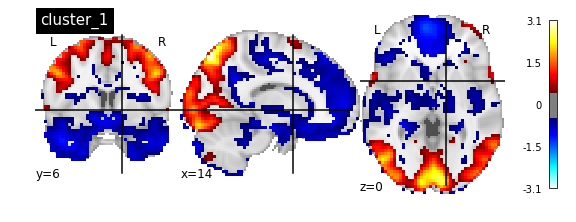

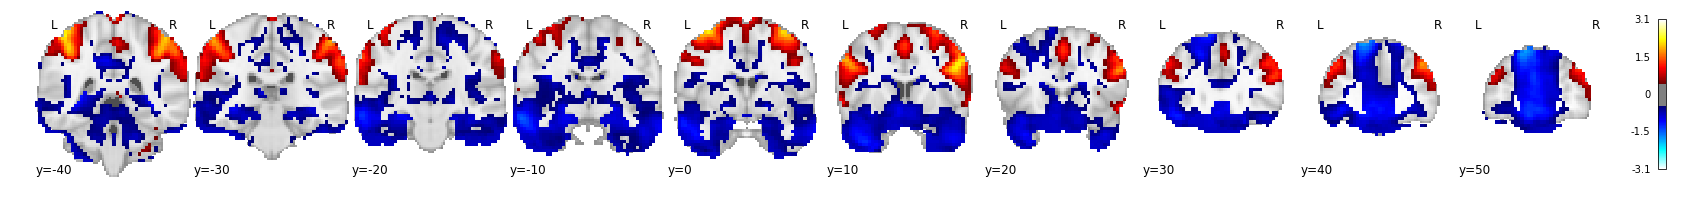

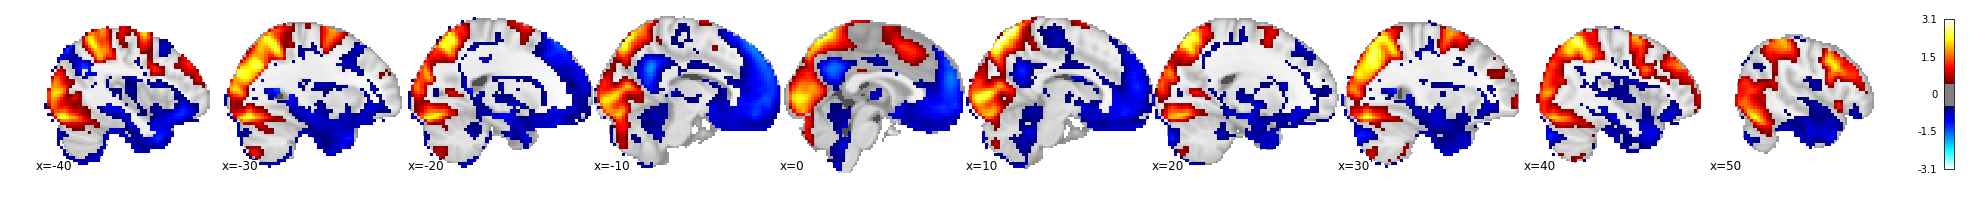

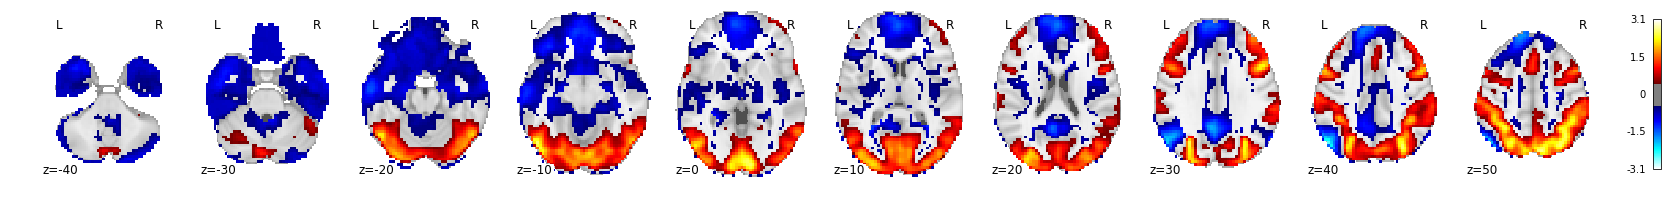

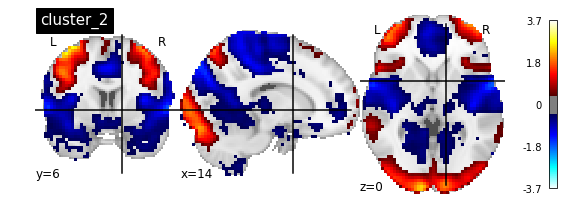

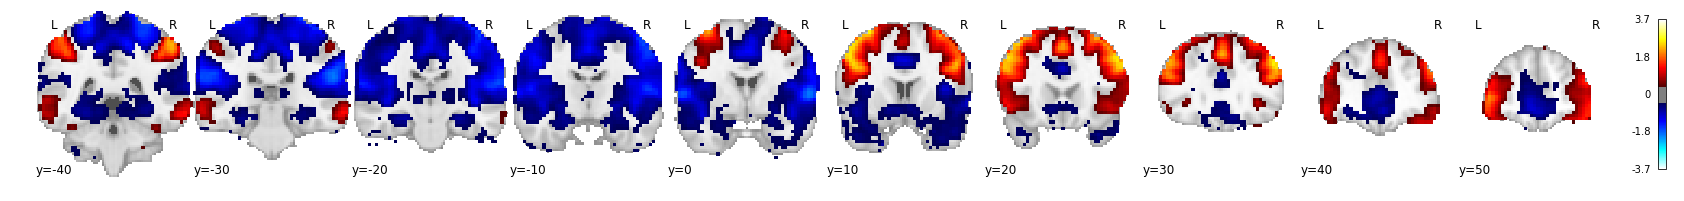

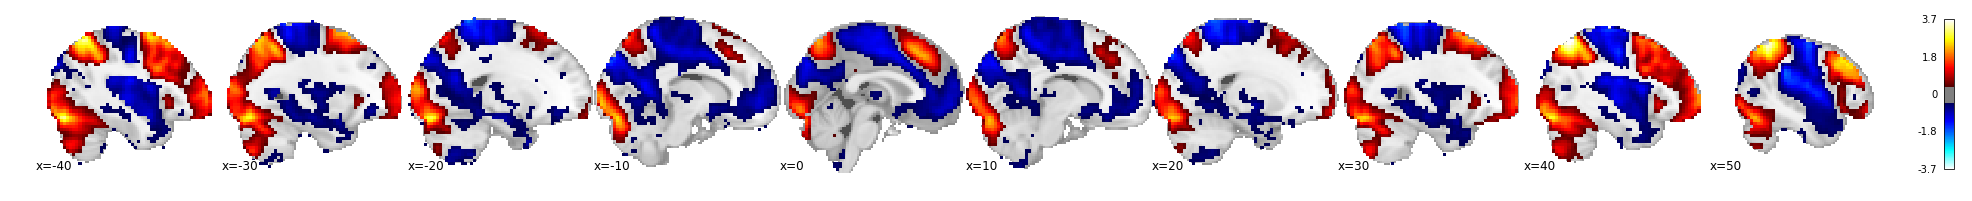

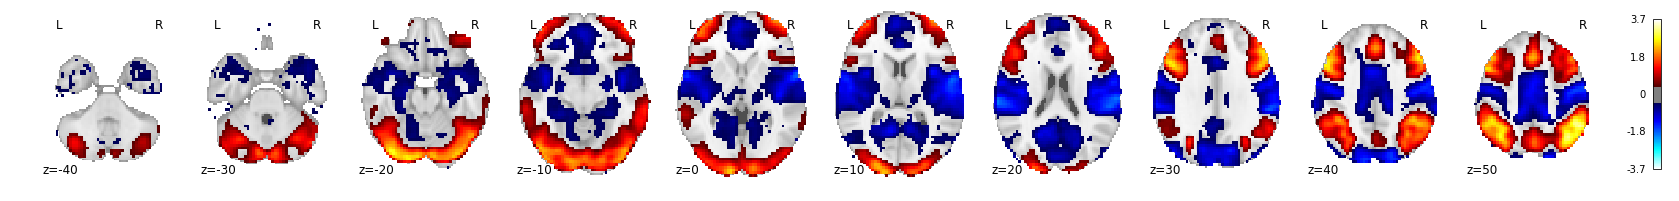

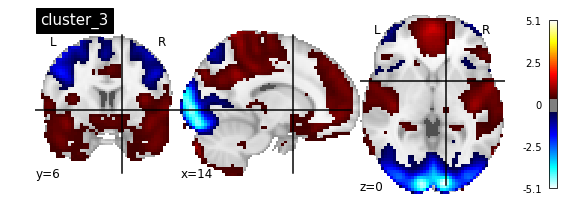

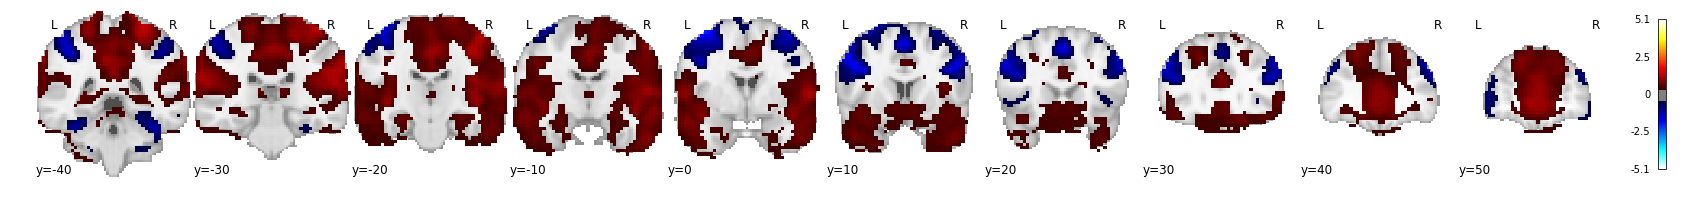

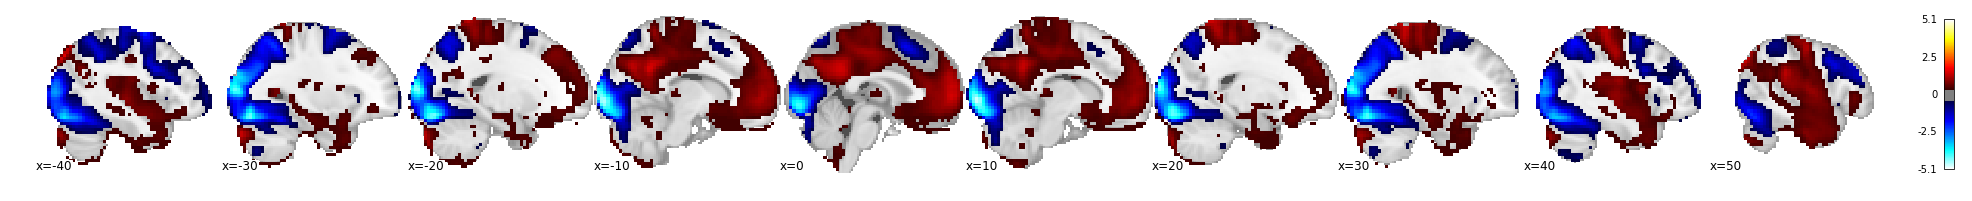

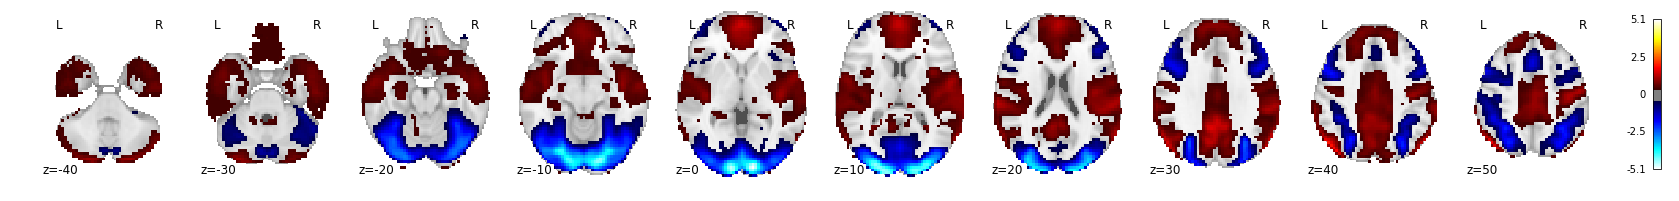

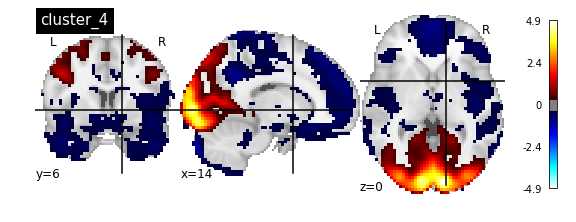

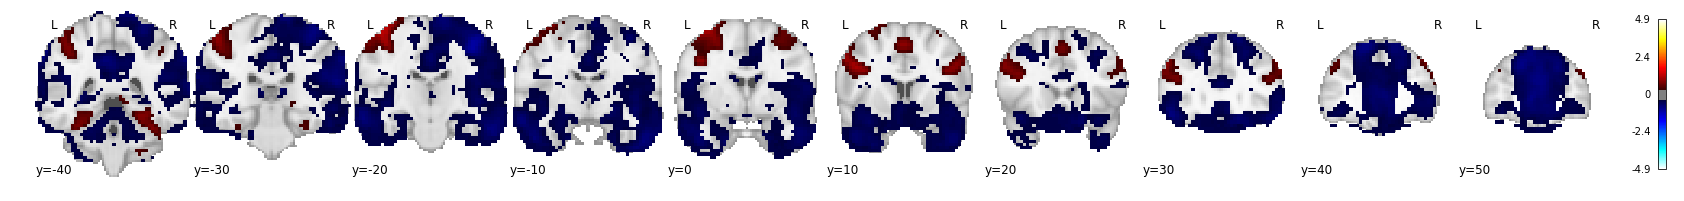

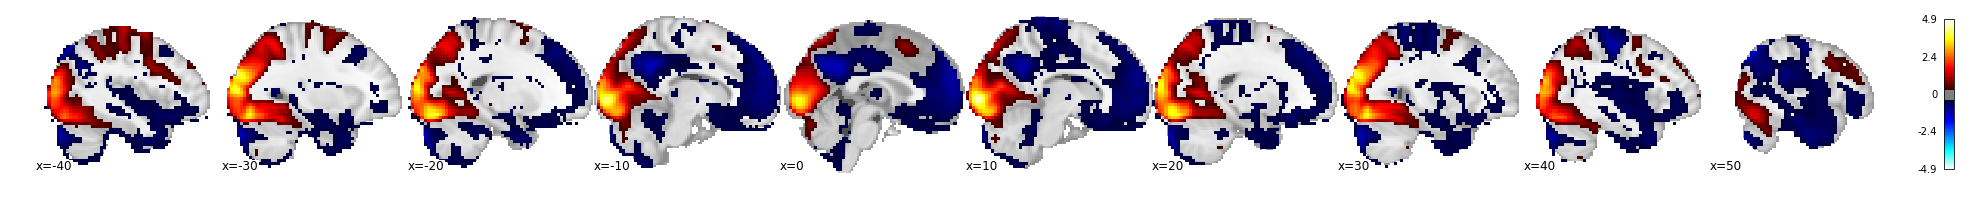

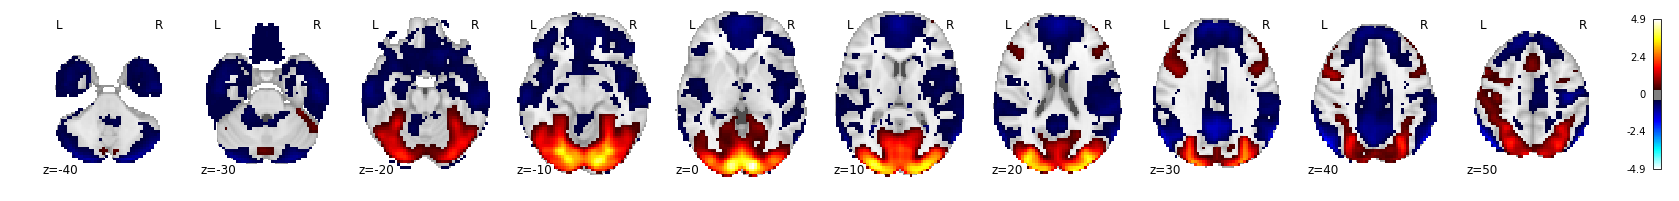

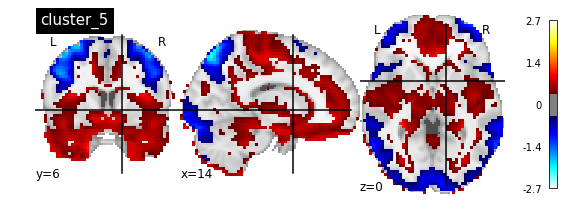

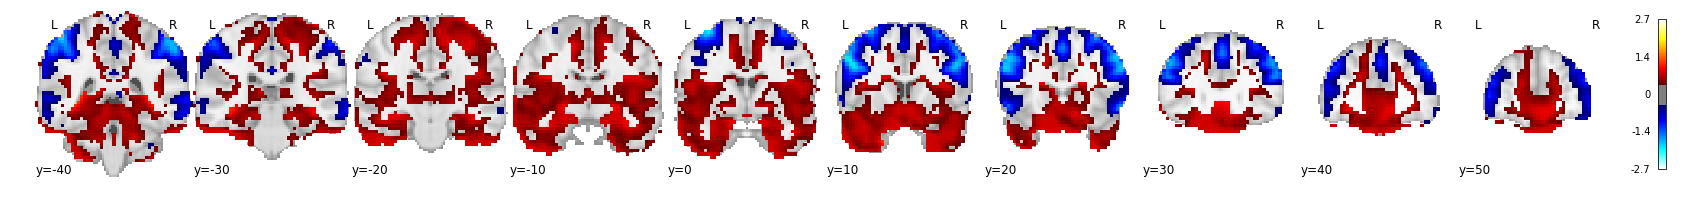

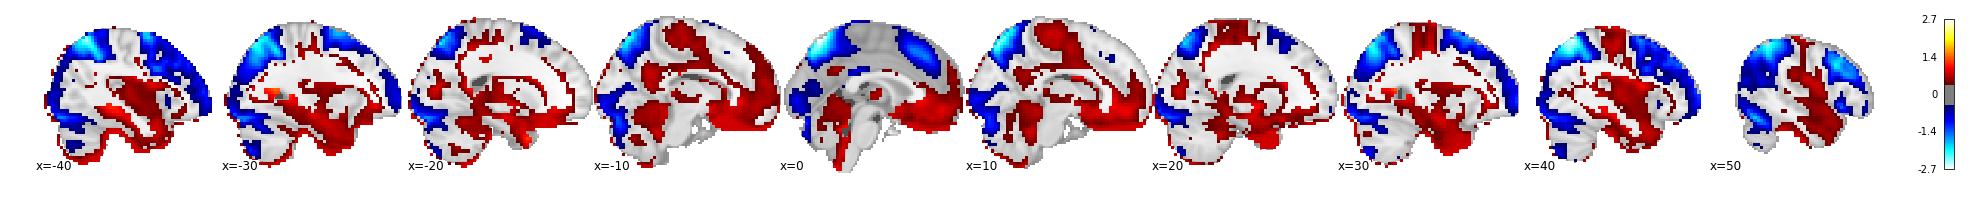

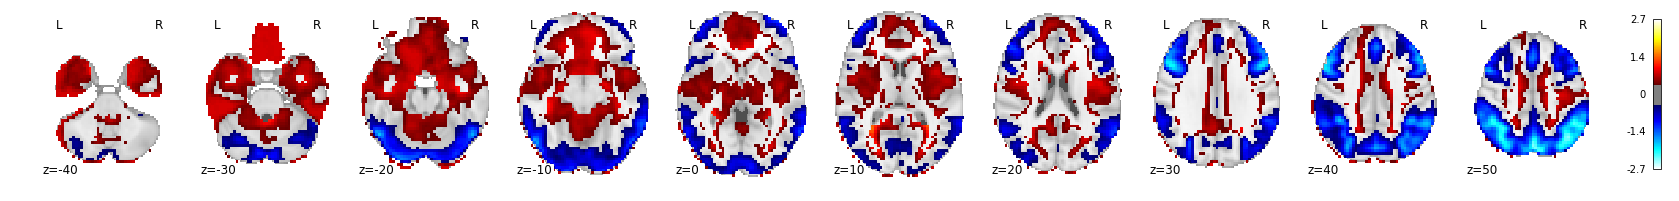

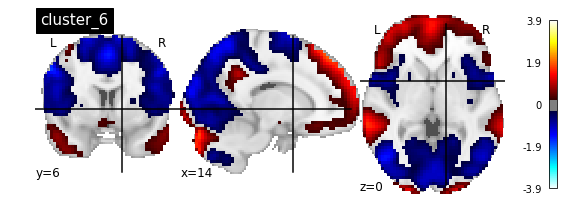

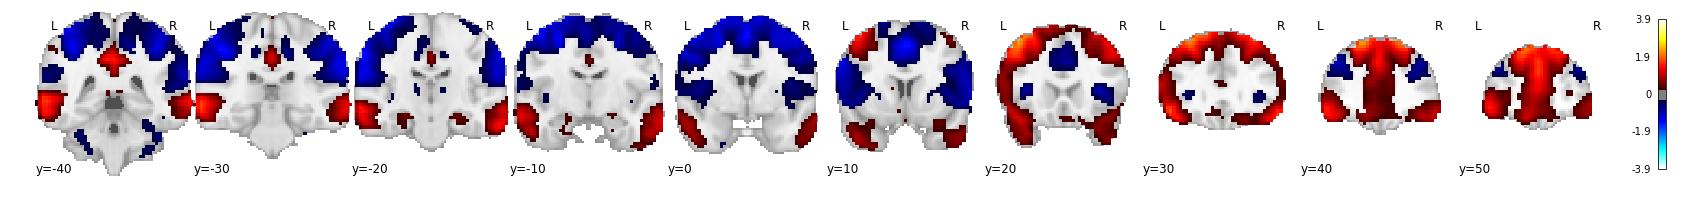

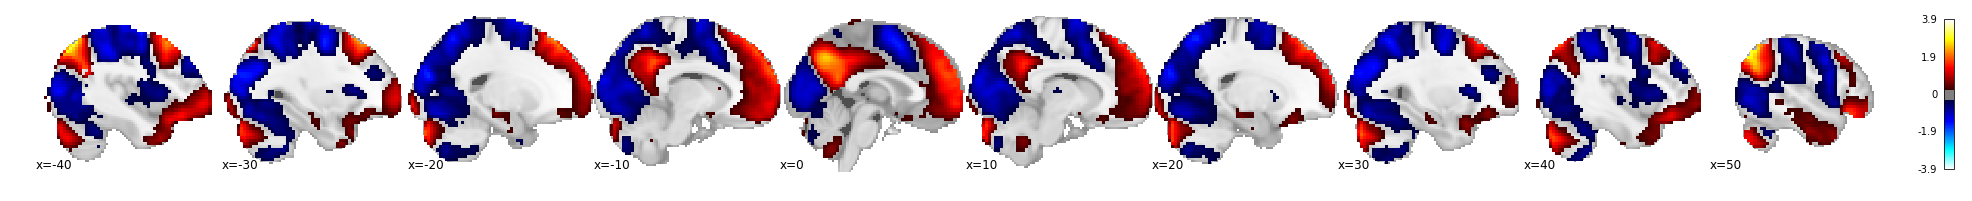

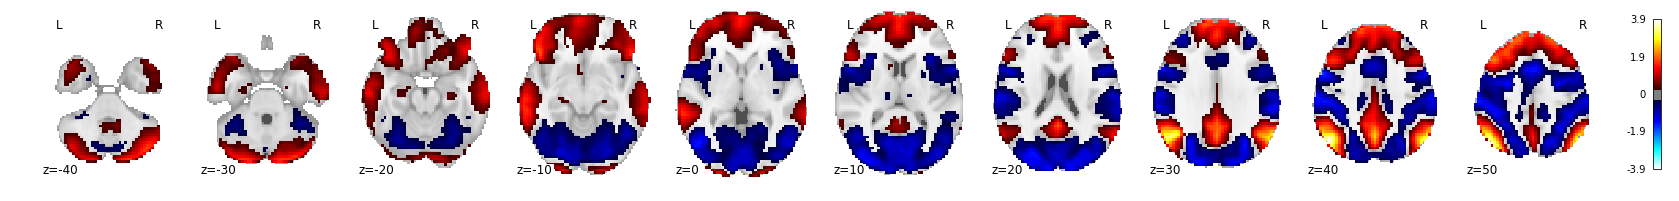

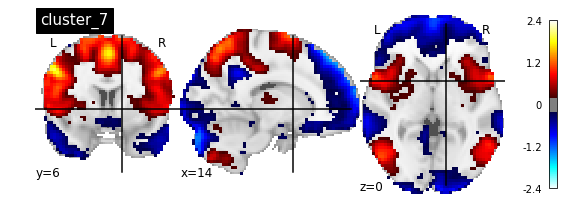

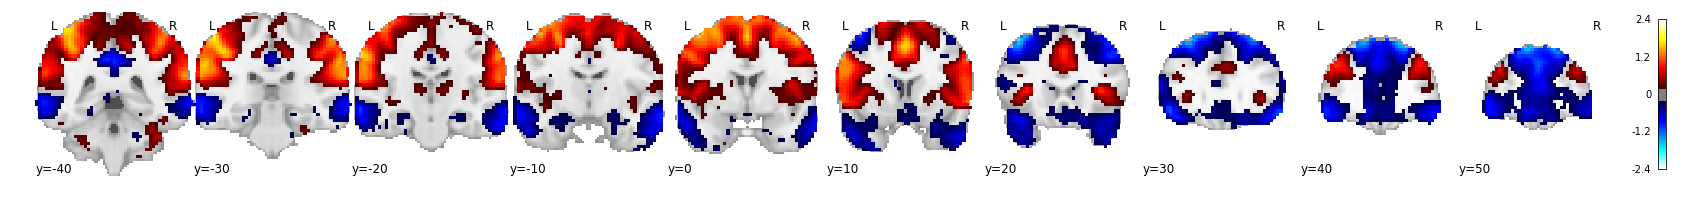

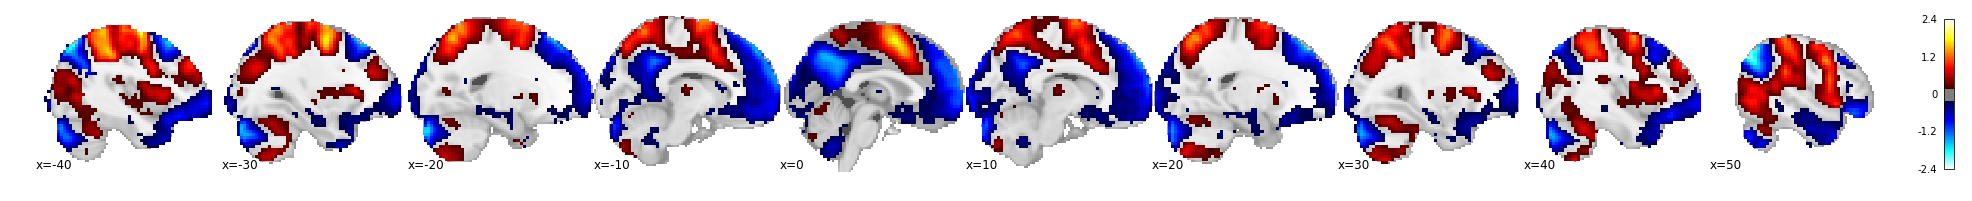

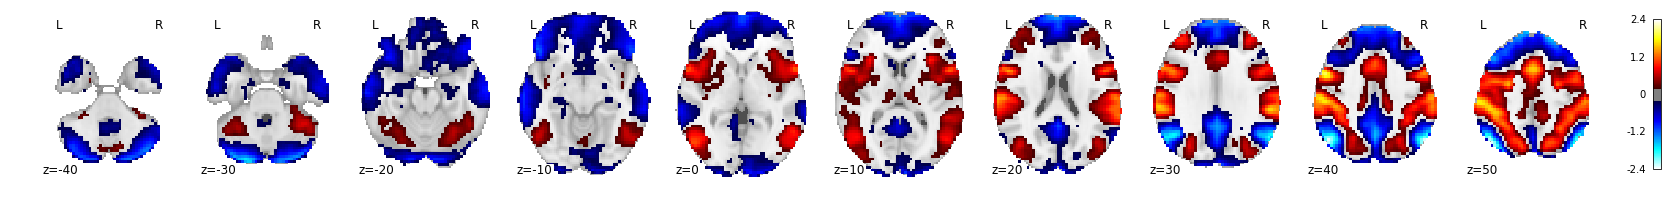

In [23]:
for cluster_num in range(int(nb_cluster)):
    sbt = stack[:,cluster_num]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    %octave_push mask sbt
    %octave vol = niak_tseries2vol(sbt,mask);
    %octave_pull vol
    sbt_img = nib.Nifti1Image(vol, affine=m_img.get_affine(), header=m_img.get_header())
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                     title= "cluster_%s" % str(cluster_num+1))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )


ans =  1

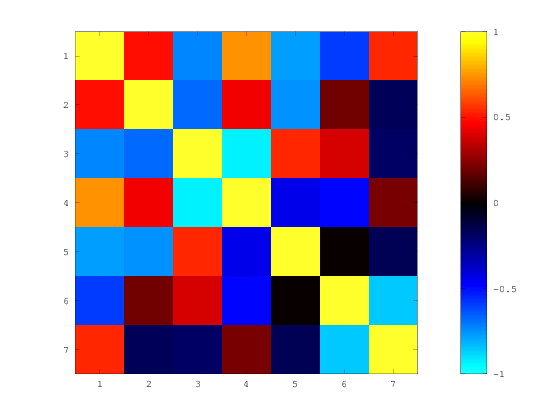

In [24]:
%%octave
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [35]:
%octave Rc

Rc =

   1.00000  -0.72730   0.72585  -0.68491   0.51075  -0.76960   0.53675

  -0.72730   1.00000  -0.93900   0.47451  -0.68151   0.54263  -0.19087

   0.72585  -0.93900   1.00000  -0.63232   0.46534  -0.38906   0.27679

  -0.68491   0.47451  -0.63232   1.00000   0.14231   0.10573  -0.84009

   0.51075  -0.68151   0.46534   0.14231   1.00000  -0.79651  -0.28678

  -0.76960   0.54263  -0.38906   0.10573  -0.79651   1.00000  -0.13067

   0.53675  -0.19087   0.27679  -0.84009  -0.28678  -0.13067   1.00000